In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random 

In [2]:
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

In [3]:
tf.random.set_seed(123)
random.seed(123)

In [4]:
df = pd.read_csv("covid19postvaxstatewidestats.csv")

df

,date,area,area_type,unvaccinated_cases,vaccinated_cases,unvaccinated_hosp,vaccinated_hosp,unvaccinated_deaths,vaccinated_deaths,population_unvaccinated,population_vaccinated,unvaccinated_cases_per_100k,vaccinated_cases_per_100k,unvaccinated_hosp_per_100k,vaccinated_hosp_per_100k,unvaccinated_deaths_per_100k,vaccinated_deaths_per_100k
0,2021-02-01,California,State,14595,24,781,1,12,0,36190068,339372,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-02-02,California,State,12076,21,599,0,15,0,36073331,373679,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-02-03,California,State,11009,25,557,0,18,0,35938325,410320,NaN,NaN,NaN,NaN,NaN,NaN
3,2021-02-04,California,State,9661,17,487,0,19,0,35774605,431692,NaN,NaN,NaN,NaN,NaN,NaN
4,2021-02-05,California,State,8984,17,507,1,27,0,35611210,447446,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
784,2023-03-27,California,State,607,1016,33,83,4,7,5591769,28898483,8.425650,3.002135,0.613146,0.266944,0.051096,0.027189
785,2023-03-28,California,State,502,980,28,74,3,9,5590686,28898869,8.210084,2.952661,0.564715,0.251122,0.048550,0.029166
786,2023-03-29,California,State,539,924,37,81,3,7,5589458,28899278,8.268116,2.931858,0.552060,0.250130,0.048561,0.029660
787,2023-03-30,California,State,481,961,38,65,5,9,5588295,28899658,8.157356,2.942200,0.570069,0.241723,0.061353,0.029659


In [5]:
df_unvac = df[['unvaccinated_cases_per_100k', 'unvaccinated_hosp_per_100k', 'unvaccinated_deaths_per_100k']]

df_unvac

,unvaccinated_cases_per_100k,unvaccinated_hosp_per_100k,unvaccinated_deaths_per_100k
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,NaN,NaN,NaN
4,NaN,NaN,NaN
...,...,...,...
784,8.425650,0.613146,0.051096
785,8.210084,0.564715,0.048550
786,8.268116,0.552060,0.048561
787,8.157356,0.570069,0.061353


In [6]:
filtered_df = df_unvac[df_unvac['unvaccinated_cases_per_100k'].notna()]

filtered_df

,unvaccinated_cases_per_100k,unvaccinated_hosp_per_100k,unvaccinated_deaths_per_100k
6,27.251295,1.483401,0.067702
7,25.072362,1.360519,0.078033
8,23.268146,1.296892,0.087677
9,21.766329,1.236441,0.099877
10,20.467271,1.179528,0.112219
...,...,...,...
784,8.425650,0.613146,0.051096
785,8.210084,0.564715,0.048550
786,8.268116,0.552060,0.048561
787,8.157356,0.570069,0.061353


In [7]:
def sequence_data(data, time_step):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), :])
        y.append(data[i+time_step,:])
    return np.array(X), np.array(y)

In [8]:
split_index = int(len(filtered_df) * 0.8)

train_data = filtered_df[:split_index].values
test_data = filtered_df[split_index:].values

# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
# train_data = scaler.fit_transform(train_data)
# test_data = scaler.transform(test_data)

X_train, y_train = sequence_data(train_data, 10)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])

X_test, y_test = sequence_data(test_data, 10)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])

In [9]:
X_train.shape

(615, 10, 3)

In [10]:
model = Sequential()
model.add(LSTM(20, input_shape = (10,3)))
model.add(Dense(10, activation='relu'))
model.add(Dense(3))


model.compile(optimizer= Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

C:\Users\dangn\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [11]:
history = model.fit(X_train, y_train, epochs=300, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4450.5728 - mae: 20.7810 - val_loss: 225.1827 - val_mae: 8.2541
Epoch 2/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4437.5645 - mae: 20.6196 - val_loss: 213.7214 - val_mae: 8.0632
Epoch 3/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4410.9766 - mae: 20.3962 - val_loss: 200.8210 - val_mae: 7.7354
Epoch 4/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4385.3320 - mae: 20.0517 - val_loss: 176.7394 - val_mae: 7.1886
Epoch 5/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4331.9893 - mae: 19.5310 - val_loss: 143.9379 - val_mae: 6.3422
Epoch 6/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4227.6060 - mae: 18.7346 - val_loss: 112.7473 - val_mae: 5.2352
Epoch 7/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4125.7397 - mae: 17.9057 - val_loss: 88.8837 - val_mae: 4.3245
Epoch 8/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4003.7231 - mae: 17.1626 - val_loss: 71.0978 - val_mae: 3.6178
Epoch 9/300
20/20 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


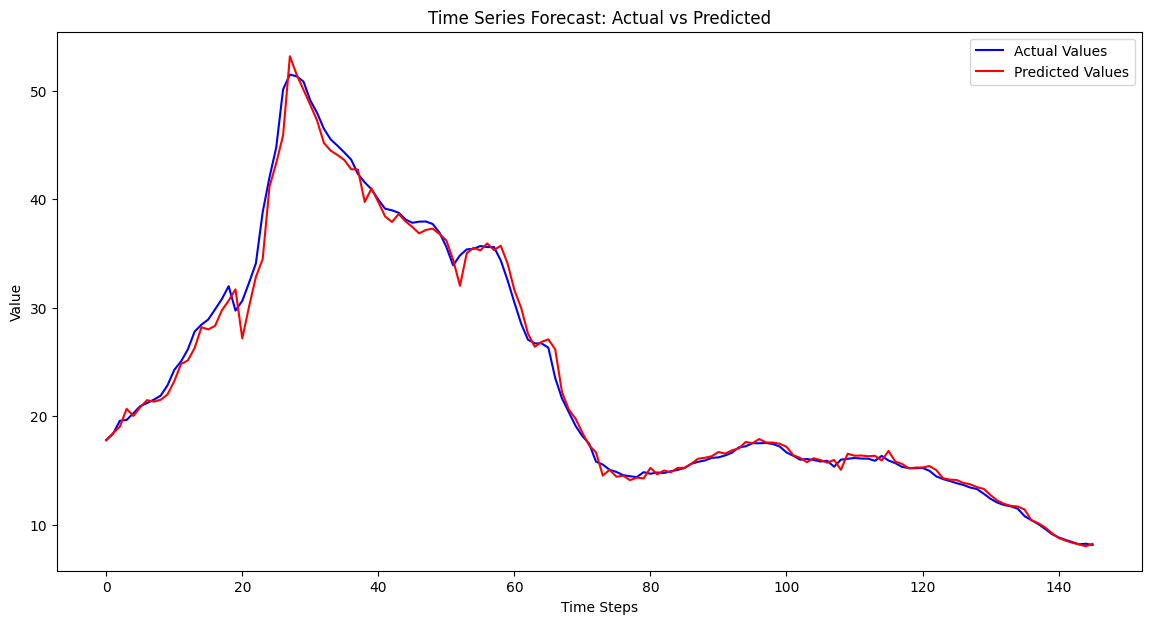

In [12]:
predictions = model.predict(X_test)

plt.figure(figsize=(14, 7))
plt.plot(y_test[:,0], label='Actual Values', color='blue')
plt.plot(predictions[:,0], label='Predicted Values', color='red')
plt.title('Time Series Forecast: Actual vs Predicted')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.legend()
plt.show()

In [13]:
df_vac = df[['vaccinated_cases_per_100k', 'vaccinated_hosp_per_100k', 'vaccinated_deaths_per_100k']]

df_vac

,vaccinated_cases_per_100k,vaccinated_hosp_per_100k,vaccinated_deaths_per_100k
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,NaN,NaN,NaN
4,NaN,NaN,NaN
...,...,...,...
784,3.002135,0.266944,0.027189
785,2.952661,0.251122,0.029166
786,2.931858,0.250130,0.029660
787,2.942200,0.241723,0.029659


In [14]:
df_vac = df_vac[df_vac['vaccinated_cases_per_100k'].notna()]

df_vac

,vaccinated_cases_per_100k,vaccinated_hosp_per_100k,vaccinated_deaths_per_100k
6,3.805800,0.092076,0.000000
7,3.546032,0.085105,0.000000
8,3.120234,0.078661,0.000000
9,2.991090,0.072953,0.000000
10,3.109945,0.091469,0.000000
...,...,...,...
784,3.002135,0.266944,0.027189
785,2.952661,0.251122,0.029166
786,2.931858,0.250130,0.029660
787,2.942200,0.241723,0.029659


In [15]:
split_index = int(len(df_vac) * 0.8)

train_vac = df_vac[:split_index].values
test_vac = df_vac[split_index:].values


X_train1, y_train1 = sequence_data(train_vac, 10)
X_train1 = X_train1.reshape(X_train1.shape[0], X_train1.shape[1], X_train1.shape[2])

X_test1, y_test1 = sequence_data(test_vac, 10)
X_test1 = X_test1.reshape(X_test1.shape[0], X_test1.shape[1], X_test1.shape[2])

In [16]:
X_train1.shape

(615, 10, 3)

In [17]:
model_vac = Sequential()
model_vac.add(LSTM(20, input_shape = (10,3)))
model_vac.add(Dense(10, activation='relu'))
model_vac.add(Dense(3))

model_vac.compile(optimizer= Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

C:\Users\dangn\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [18]:
history1 = model_vac.fit(X_train1, y_train1, epochs=300, batch_size=32, validation_data=(X_test1, y_test1))

Epoch 1/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 617.3745 - mae: 7.4047 - val_loss: 37.3510 - val_mae: 3.2927
Epoch 2/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 611.8348 - mae: 7.1663 - val_loss: 33.7034 - val_mae: 3.1094
Epoch 3/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 605.5164 - mae: 7.0090 - val_loss: 28.6241 - val_mae: 2.7879
Epoch 4/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 596.3118 - mae: 6.8356 - val_loss: 22.9862 - val_mae: 2.4711
Epoch 5/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 582.2451 - mae: 6.5860 - val_loss: 17.8770 - val_mae: 2.1351
Epoch 6/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 565.2324 - mae: 6.2137 - val_loss: 13.6552 - val_mae: 1.7082
Epoch 7/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 545.3676 - mae: 5.7803 - val_loss: 10.2777 - val_mae: 1.2910
Epoch 8/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 528.7751 - mae: 5.4048 - val_loss: 7.4746 - val_mae: 1.0785
Epoch 9/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 0

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


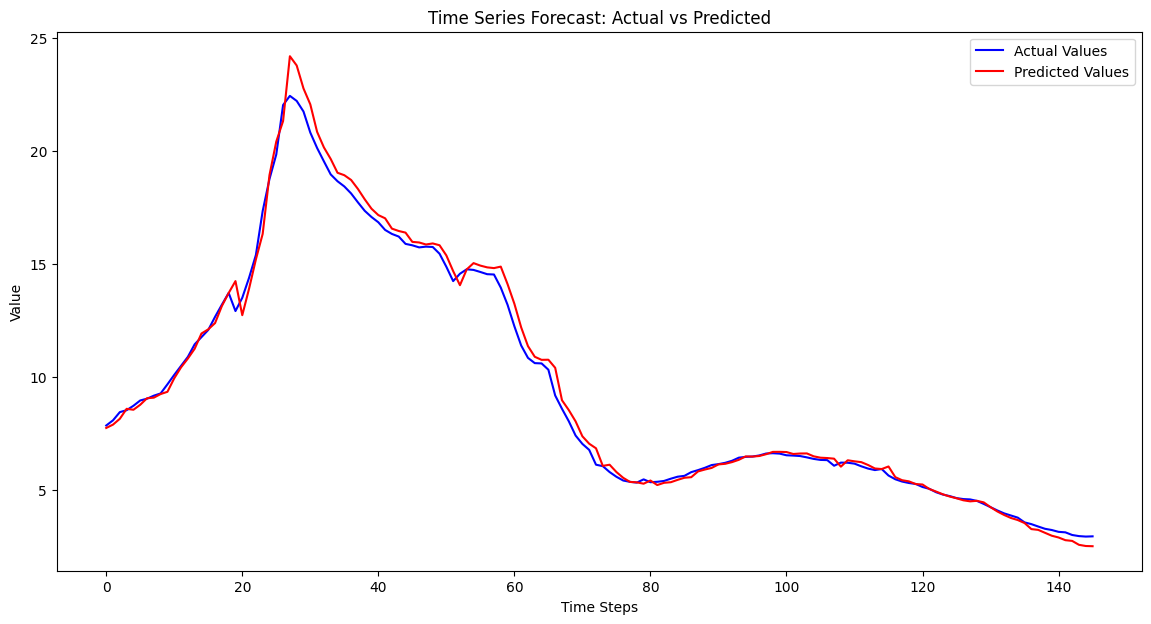

In [19]:
predictions_vac = model_vac.predict(X_test1)

plt.figure(figsize=(14, 7))
plt.plot(y_test1[:,0], label='Actual Values', color='blue')
plt.plot(predictions_vac[:,0], label='Predicted Values', color='red')
plt.title('Time Series Forecast: Actual vs Predicted')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.legend()
plt.show()

In [20]:
# from sklearn.metrics import mean_squared_error, r2_score

# mse = mean_squared_error(y_test[:,0], predictions[:,0])
# r2 = r2_score(y_test[:,0], predictions[:,0])
# mae = np.mean(np.abs(y_test[:,0] - predictions[:,0]))

# print("Regression Metrics:")
# print(f"Mean Squared Error (MSE): {mse}")
# print(f"Mean Absolute Error (MAE): {mae}")
# print(f"R-squared (R2): {r2}")


In [21]:
forecast = 30

forecast_unvac = filtered_df[-10:].values
forecast_vac = df_vac[-10:].values

forecast_unvac = forecast_unvac.reshape((1,10,3))
forecast_vac = forecast_vac.reshape((1,10,3))

In [22]:
predictions_unvac = []
predictions_vac = []

for i in range(forecast):
    next_unvac = model.predict(forecast_unvac)
    next_vac = model_vac.predict(forecast_vac)

    next_unvac = next_unvac.reshape((1,1,3))
    next_vac = next_vac.reshape((1,1,3))

    forecast_unvac = np.append(forecast_unvac[:, 1:, :], next_unvac, axis = 1)
    forecast_vac = np.append(forecast_vac[:, 1:, :], next_vac, axis = 1)

    predictions_unvac.append(next_unvac[0, -1, 0])
    predictions_vac.append(next_vac[0, -1, 0])


predictions_unvac = np.array(predictions_unvac)
predictions_vac = np.array(predictions_vac)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━

In [23]:
last_df = df[['date', 'unvaccinated_cases_per_100k']]

last_df = last_df[last_df['unvaccinated_cases_per_100k'].notnull()]

last_df

,date,unvaccinated_cases_per_100k
6,2021-02-07,27.251295
7,2021-02-08,25.072362
8,2021-02-09,23.268146
9,2021-02-10,21.766329
10,2021-02-11,20.467271
...,...,...
784,2023-03-27,8.425650
785,2023-03-28,8.210084
786,2023-03-29,8.268116
787,2023-03-30,8.157356


In [24]:
last_date = last_df['date'].iloc[-1]

last_date

next_month = pd.date_range(start = last_date, periods = 31, closed = 'right')

next_month

C:\Users\dangn\AppData\Local\Temp\ipykernel_17552\3089131202.py:5: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  next_month = pd.date_range(start = last_date, periods = 31, closed = 'right')


DatetimeIndex(['2023-04-01', '2023-04-02', '2023-04-03', '2023-04-04',
               '2023-04-05', '2023-04-06', '2023-04-07', '2023-04-08',
               '2023-04-09', '2023-04-10', '2023-04-11', '2023-04-12',
               '2023-04-13', '2023-04-14', '2023-04-15', '2023-04-16',
               '2023-04-17', '2023-04-18', '2023-04-19', '2023-04-20',
               '2023-04-21', '2023-04-22', '2023-04-23', '2023-04-24',
               '2023-04-25', '2023-04-26', '2023-04-27', '2023-04-28',
               '2023-04-29', '2023-04-30'],
              dtype='datetime64[ns]', freq='D')

(array([19448., 19452., 19456., 19460., 19464., 19468., 19472., 19476.,
        19478.]),
 [Text(19448.0, 0, '2023-04-01'),
  Text(19452.0, 0, '2023-04-05'),
  Text(19456.0, 0, '2023-04-09'),
  Text(19460.0, 0, '2023-04-13'),
  Text(19464.0, 0, '2023-04-17'),
  Text(19468.0, 0, '2023-04-21'),
  Text(19472.0, 0, '2023-04-25'),
  Text(19476.0, 0, '2023-04-29'),
  Text(19478.0, 0, '2023-05-01')])

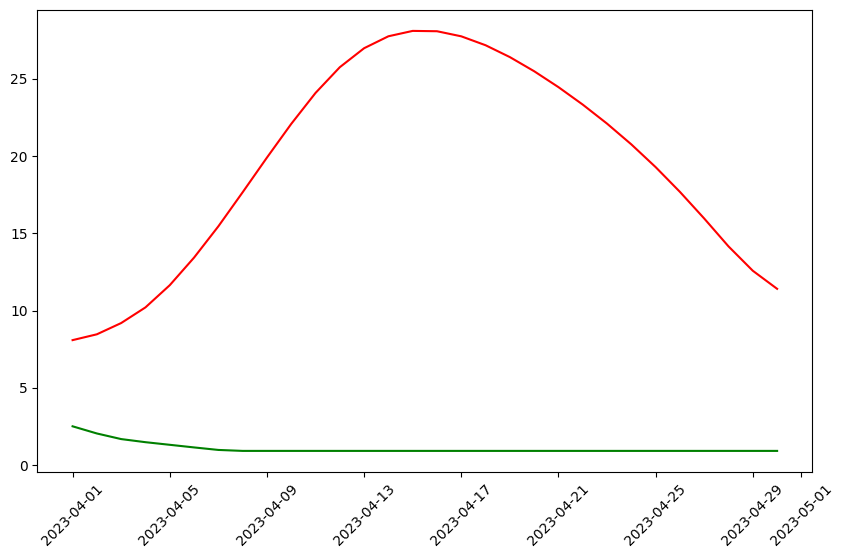

In [25]:
plt.figure(figsize=(10,6))
plt.plot(next_month, predictions_vac, color = 'g')
plt.plot(next_month, predictions_unvac, color = "r")
plt.xticks(rotation = 45)

In [26]:
# model.save('models/multivariate_unvac.keras')
# model_vac.save('models/multivariate_vac.keras')